In [45]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers, models
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

# CNN 4 - only keep the first layer of each block

In [46]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'Polyp_copy/train'
validation_data_dir = 'Polyp_copy/validation'

# Image generation 
train_datagen = ImageDataGenerator(
     rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
     height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 # Image generation 

validation_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=45,
      width_shift_range=0.3,
    height_shift_range=0.3,
      horizontal_flip=True,
     fill_mode='nearest'
)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 25

 # Standardize image size
img_rows, img_cols = 224, 224 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [47]:
Pre_trained_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layer in Pre_trained_model.layers:
    layer.trainable = True

Pre_trained_model.layers[1].trainable = False
Pre_trained_model.layers[4].trainable = False
Pre_trained_model.layers[7].trainable = False
Pre_trained_model.layers[11].trainable = False
Pre_trained_model.layers[15].trainable = False

for layer in Pre_trained_model.layers:
    print(layer.name)
    print(layer.trainable)

input_2
True
block1_conv1
False
block1_conv2
True
block1_pool
True
block2_conv1
False
block2_conv2
True
block2_pool
True
block3_conv1
False
block3_conv2
True
block3_conv3
True
block3_pool
True
block4_conv1
False
block4_conv2
True
block4_conv3
True
block4_pool
True
block5_conv1
False
block5_conv2
True
block5_conv3
True
block5_pool
True


In [48]:
Pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [49]:
last_layer = Pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


In [50]:
# DEFINE the Model
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='sigmoid')(x)

# Configure and compile the model

model = tf.keras.Model(Pre_trained_model.input, x)

optimizer = SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

In [51]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [52]:
#Training the MODEL Feature-Extraction
#If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of 
# feature extraction first so that weights of the final fully connected layer aren't completely random. 
#The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large
#and will change the pretrained weights too much.
# Enter the number of training and validation samples here
nb_train_samples = 300
nb_validation_samples = 100

# We only train 5 EPOCHS 
epochs = 70
# batch_size = 25

r = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/70


2023-03-23 22:36:18.328489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 0.7776 - acc: 0.4900

2023-03-23 22:36:54.061307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 40s 3s/step - loss: 0.7776 - acc: 0.4900 - val_loss: 0.6863 - val_acc: 0.5600
Epoch 2/70
12/12 [==============================] - 36s 3s/step - loss: 0.7363 - acc: 0.5733 - val_loss: 0.6697 - val_acc: 0.6000
Epoch 3/70
12/12 [==============================] - 35s 3s/step - loss: 0.7402 - acc: 0.5167 - val_loss: 0.6681 - val_acc: 0.6400
Epoch 4/70
12/12 [==============================] - 36s 3s/step - loss: 0.7183 - acc: 0.5533 - val_loss: 0.6524 - val_acc: 0.6700
Epoch 5/70
12/12 [==============================] - 36s 3s/step - loss: 0.7134 - acc: 0.5500 - val_loss: 0.6380 - val_acc: 0.7300
Epoch 6/70
12/12 [==============================] - 36s 3s/step - loss: 0.6675 - acc: 0.6333 - val_loss: 0.6302 - val_acc: 0.7100
Epoch 7/70
12/12 [==============================] - 36s 3s/step - loss: 0.6618 - acc: 0.6300 - val_loss: 0.6166 - val_acc: 0.7000
Epoch 8/70
12/12 [==============================] - 36s 3s/step - loss: 0.6163 - acc: 0.6800 - val_lo

Epoch 64/70
12/12 [==============================] - 23s 2s/step - loss: 0.0896 - acc: 0.9800 - val_loss: 0.1875 - val_acc: 0.9200
Epoch 65/70
12/12 [==============================] - 23s 2s/step - loss: 0.2613 - acc: 0.9167 - val_loss: 0.2411 - val_acc: 0.8800
Epoch 66/70
12/12 [==============================] - 23s 2s/step - loss: 0.1183 - acc: 0.9700 - val_loss: 0.2081 - val_acc: 0.9200
Epoch 67/70
12/12 [==============================] - 23s 2s/step - loss: 0.1071 - acc: 0.9700 - val_loss: 0.1628 - val_acc: 0.9100
Epoch 68/70
12/12 [==============================] - 26s 2s/step - loss: 0.0966 - acc: 0.9800 - val_loss: 0.2084 - val_acc: 0.8900
Epoch 69/70
12/12 [==============================] - 42s 4s/step - loss: 0.1028 - acc: 0.9700 - val_loss: 0.2580 - val_acc: 0.8900
Epoch 70/70
12/12 [==============================] - 51s 4s/step - loss: 0.1587 - acc: 0.9367 - val_loss: 0.2375 - val_acc: 0.9000


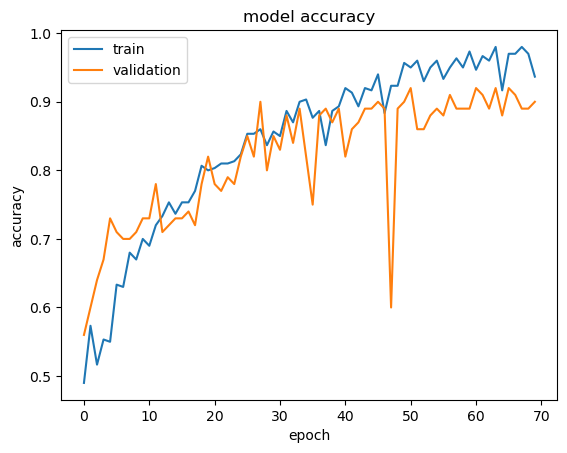

In [53]:
plt.plot(r.history['acc'])
plt.plot(r.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

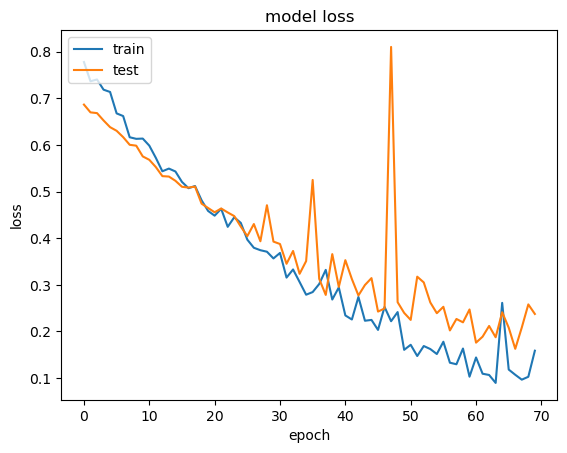

In [54]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
model2 = Sequential()
for layer in model.layers[:-4]:
    model2.add(layer)

In [56]:
# training data for SVM Classifier
X_train, y_train = next(train_generator)
for i in range((300//batch_size) - 1):
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

(300, 224, 224, 3) (300, 2)


In [57]:
# validation data for SVM Classifier
X_valid, y_valid = next(validation_generator)
for i in range((100//batch_size) - 1):
    img, label = next(validation_generator)
    X_valid = np.append(X_valid, img, axis=0 )
    y_valid = np.append(y_valid, label, axis=0)
print(X_valid.shape, y_valid.shape)

(100, 224, 224, 3) (100, 2)


In [58]:
feature_mapping = model2(X_train)

In [59]:
clf = svm.SVC()

lenofimageT = len(X_train)
feature_mapping2 = np.array(feature_mapping).reshape(lenofimageT, -1)
clf.fit(feature_mapping2, y_train.argmax(axis=1))

SVC()

In [60]:
features = model2(X_valid)
lenofimageV = len(X_valid)
features2 = np.array(features).reshape(lenofimageV, -1)




In [61]:
predictionSVM = clf.predict(features2)

Accuracy = 0.88
Recall = 0.8653846153846154
Precision = 0.9


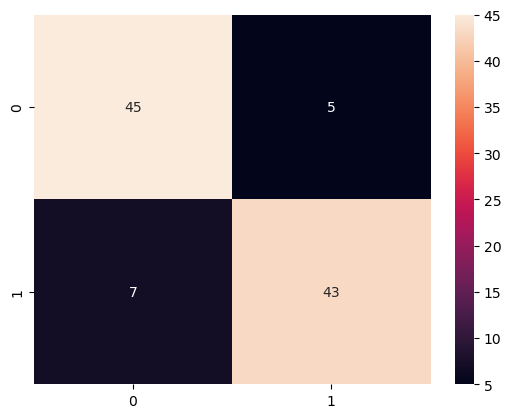

In [62]:
cm = confusion_matrix(y_valid.argmax(axis=1), predictionSVM)
sns.heatmap(cm, annot = True) 
tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_valid.argmax(axis=1), predictionSVM))
print("Recall =", recall)
print("Precision =", precision)

Random Forest

In [27]:
model3 = Sequential()
for layer in model.layers[:-4]:
    model3.add(layer)

In [28]:
feature_mapping = model3(X_train)
clf = RandomForestClassifier(n_estimators=100)

In [29]:
lenofimageT = len(X_train)
feature_mapping2 = np.array(feature_mapping).reshape(lenofimageT, -1)
clf.fit(feature_mapping2, y_train.argmax(axis=1))

RandomForestClassifier()

In [30]:
features = model2(X_valid)
lenofimageV = len(X_valid)
features2 = np.array(features).reshape(lenofimageV, -1)

In [33]:
predictionRF = clf.predict(features2)

Accuracy = 0.82
Recall = 0.8809523809523809
Precision = 0.74


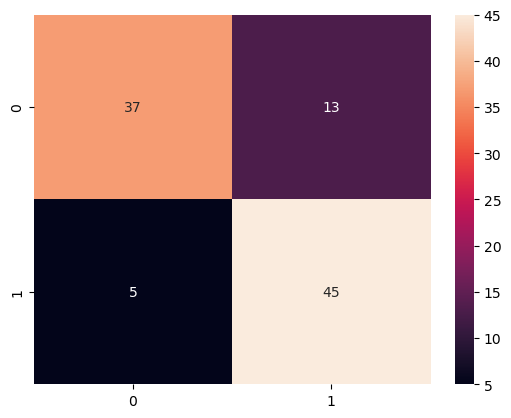

In [36]:
cm = confusion_matrix(y_valid.argmax(axis=1), predictionRF)
sns.heatmap(cm, annot = True) 
tp, fp, fn, tn = cm.ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print('Accuracy =', metrics.accuracy_score(y_valid.argmax(axis=1), predictionRF))
print("Recall =", recall)
print("Precision =", precision)

In [63]:
df1 = pd.DataFrame(r.history['acc']) 
df2 = pd.DataFrame(r.history['val_acc'])
df3 = pd.DataFrame(r.history['loss'])
df4 = pd.DataFrame(r.history['val_loss'])



df1.to_csv('bt_acc1.csv', header = False)
df2.to_csv('bt_Vacc1.csv', header = False)
df3.to_csv('bt_loss1.csv', header = False)
df4.to_csv('bt_Vloss1.csv', header = False)